# Loan Default Classifier

In this project, we will build a classifier to predict whether a loan case will be paid off or not.

We load a historical dataset from previous loan applications, clean the data, and apply different classification algorithm on the data.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-07 22:11:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-03-07 22:11:04 (11.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [94]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [6]:
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00  49.34 MB/s


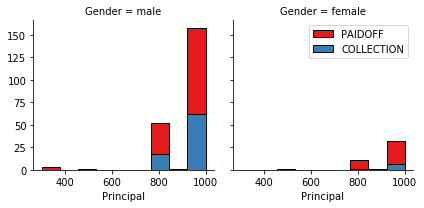

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

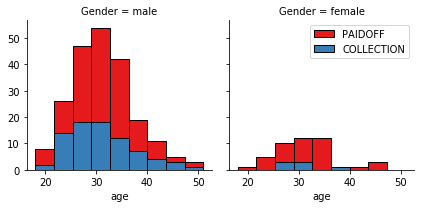

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

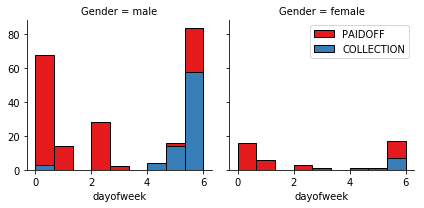

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### Using Education

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Using one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, using the training set we build an accurate model. Then we use the test set to report the accuracy of the model.
We use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

In [19]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print('X_train.shape',X_train.shape, 'y_train.shape', y_train.shape)
print('X_test.shape',X_test.shape, 'y_test.shape', y_test.shape)

X_train.shape (242, 8) y_train.shape (242,)
X_test.shape (104, 8) y_test.shape (104,)


In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.neighbors as neig
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN = neig.KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat= KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

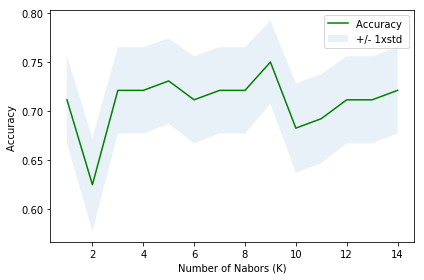

The best accuracy was with 0.75 with k= 9


array([[ 9, 18],
       [ 8, 69]])

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
KNN=neig.KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train,y_train)
yhat=KNN.predict(X_test)
confusion_matrix(y_test,yhat)

# Decision Tree

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

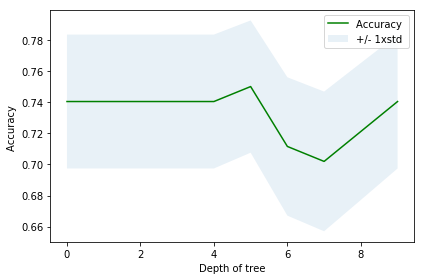

The best accuracy was with 0.75 with depth =  6


In [25]:
from sklearn.tree import DecisionTreeClassifier
acc_mean = np.zeros(10)
acc_std = np.zeros(10)
for counter, depth in enumerate(range(10)):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = depth+1).fit(X_train,y_train)
    yhat = tree.predict(X_test)
    acc_mean[counter-1] = metrics.accuracy_score(y_test,yhat)
    acc_std[counter-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(10),acc_mean,'g')
plt.fill_between(range(10), acc_mean - 1*acc_std,acc_mean + 1*acc_std, alpha=0.10)
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth of tree')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", acc_mean.max(), "with depth = ", acc_mean.argmax()+1)

DecisionTrees's Accuracy: 0.74
             precision    recall  f1-score   support

 COLLECTION       0.50      0.04      0.07        27
    PAIDOFF       0.75      0.99      0.85        77

avg / total       0.68      0.74      0.65       104

Confusion matrix, without normalization
[[ 1 26]
 [ 1 76]]


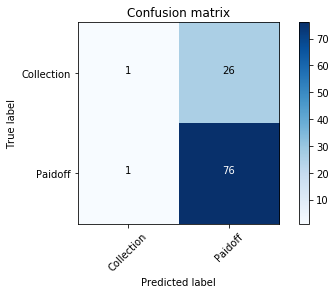

In [26]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = acc_mean.argmax()+1).fit(X_train,y_train)
yhat = tree.predict(X_test)
print("DecisionTrees's Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, yhat)))
print(classification_report(y_test, yhat))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test,yhat,labels=["COLLECTION","PAIDOFF"]), 
                      classes=['Collection','Paidoff'], normalize= False,  title='Confusion matrix')

# Support Vector Machine

In [27]:
from sklearn import svm

In [28]:
kernel = ['rbf','poly','sigmoid','linear']
accuracy = np.zeros(4)
for i in range(4):
    separator = svm.SVC(kernel=kernel[i],gamma='auto',probability=True)
    separator.fit(X_train, y_train)
    yhat = separator.predict(X_test)
    accuracy[i] = metrics.accuracy_score(y_test, yhat)
    print("SVM with {} kernel has Accuracy: {}".format(kernel[i], metrics.accuracy_score(y_test, yhat)))
accuracy.argmax()

SVM with rbf kernel has Accuracy: 0.75
SVM with poly kernel has Accuracy: 0.75
SVM with sigmoid kernel has Accuracy: 0.7115384615384616
SVM with linear kernel has Accuracy: 0.7403846153846154


0

In [29]:
separator = svm.SVC(kernel=kernel[accuracy.argmax()],gamma='auto',probability=True)
separator.fit(X_train, y_train)
yhat = separator.predict(X_test)
separator.predict_proba(X_test)[0:5]
confusion_matrix(yhat,y_test)

array([[ 1,  0],
       [26, 77]])

# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat = LR.predict(X_test)
y_prob = LR.predict_proba(X_test)

In [32]:
# Plot non-normalized confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
plt.figure()
print('Accuracy score for training set: {:.2f}'.format(accuracy_score(y_true=y_train,y_pred=LR.predict(X_train))))
print('Accuracy score for test set: {:.2f}'.format(accuracy_score(y_true=y_test,y_pred=yhat)))
print (classification_report(y_test, yhat))
confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF'])

Accuracy score for training set: 0.76
Accuracy score for test set: 0.74
             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        27
    PAIDOFF       0.74      1.00      0.85        77

avg / total       0.55      0.74      0.63       104



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 0, 27],
       [ 0, 77]])

# Model Evaluation using Test set

In [33]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-01-29 20:00:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-01-29 20:00:57 (709 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,1


In [64]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X=Feature
y=test_df['loan_status'].values
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
val,count=np.unique(y,return_counts=True)
val,count

(array(['COLLECTION', 'PAIDOFF'], dtype=object), array([14, 40]))

In [99]:
jaccard=np.zeros(4)
f1=jaccard
yhat1=KNN.predict(X)
yhat2=tree.predict(X)
yhat3=separator.predict(X)
yhat4=LR.predict(X)
yhat4_prob = LR.predict_proba(X)
ypred=[yhat1,yhat2,yhat3,yhat4]
for i in range(4):
    jaccard[i] = jaccard_similarity_score(y_true=y,y_pred=ypred[i])
    f1[i]=f1_score(y,ypred[i],average='weighted')
logloss=log_loss(y,yhat4_prob)

             Algorithm  F1-score   Jaccard  LogLoss
0                  KNN  0.592593  0.592593       NA
1        Decision Tree  0.615152  0.615152       NA
2                  SVM  0.630418  0.630418       NA
3  Logistic Regression  0.630418  0.630418  0.55724


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report

In [101]:
report_df = pd.DataFrame({'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],
                         'Jaccard':jaccard,'F1-score':f1,
                         'LogLoss':['NA','NA','NA',logloss]})
report_df

,Algorithm,F1-score,Jaccard,LogLoss
0,KNN,0.592593,0.592593,NA
1,Decision Tree,0.615152,0.615152,NA
2,SVM,0.630418,0.630418,NA
3,Logistic Regression,0.630418,0.630418,0.55724
